# preprocess of recurrence

In [1]:
# 基本的なライブラリ
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# split data
from sklearn.model_selection import train_test_split

# scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# sampling
from imblearn.over_sampling import SMOTE

# clustering
from sklearn.decomposition import PCA

# feature selection
from sklearn.feature_selection import VarianceThreshold
from boruta import BorutaPy

# https://github.com/smazzanti/mrmr
# pipでinstallはできたが、そのままimportできなかったので、
# ライブラリのソースコードをそのまま環境に設置
from libraries.mrmr import mrmr

import config
import functions

SEED = config.SEED
THRESHOLD_YEARS = config.THRESHOLD_YEARS
THRESHOLD_MONTHS = config.THRESHOLD_MONTHS
TARGET_NAME = "RFS_OVER_{0}MONTHS".format(THRESHOLD_MONTHS)
functions.fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# データ読み込み

In [2]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")

## カラムの順序変更（読みやすさのため）

In [3]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    _df = df.copy()
    df_tmp = _df.filter(regex=regex)
    # 元のdfから落とす
    _df.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(_df, df_tmp, right_index=True, left_index=True)


def sort_columns_by_knowledge(df):
    _df = df.copy()
    # 癌の種類
    _df = align_columns(_df, "^CANCER_")
    # 重要そう（直感）な特徴量
    _df = align_columns(_df, "^ER_|^HER2_|^TUMOR_")
    # 治療の種類
    _df = align_columns(_df, ".*THERAPY$|^BREAST_SURGERY")
    # target系の種類（OS, RFS, VITAL）
    _df = align_columns(_df, "^OS_.*|^RFS_.*|^VITAL_.*")
    return _df


df_clinical = sort_columns_by_knowledge(df_clinical)

In [4]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]

df_MB.set_index("PATIENT_ID", inplace=True)
df_MTST.set_index("PATIENT_ID", inplace=True)

display(df_MB.shape, df_MTST.shape)
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_clinical.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MTST.pkl")
del df_patient, df_sample, df_clinical, df_MB, df_MTST

(1985, 35)

(524, 35)

## 臨床データの読み込み

In [5]:
df_MB = pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")

## 遺伝子データの読み込み

In [6]:
# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()
"""
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()

# cnaデータ
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T.sort_index()
"""
pass

# 前処理
- 目的変数生成
- 特徴量生成
- 特徴名のrename 
- 欠損値の削除


## 目的変数の生成

モデルに入力する段階の仮定として、再発は既に判明している（データ取得時にはすでに手術を終えている状況であり、再発の有無についても見ているため）。
そこで、【再発年数が**n年**以内か、以後か】に注目し、RFS_MONTHSから目的変数を生成する。    
RFS_MONTHSは非再発者の最終フォローアップまでの月数も記録されているが、そちらはデータフレームを操作するときにRFS_STATUSからフィルタリングする。

## 特徴量生成
予測の**層別化に必要な特徴を生成**する。

**層別化に必要な特徴**
- CLAUDIN_SUBTYPE
- NPI
- TUMOR_SIZE
- LYMPH_NODES_EXAMINED_POSITIVE

数値データは層別化のためにカテゴリ化を行う。
各カテゴリ化の根拠は以下の通り。
- NPI：( ノッティンガムの予後指数：https://en.wikipedia.org/wiki/Nottingham_Prognostic_Index )
- TUMOR_SIZE：乳癌のステージの定義( https://oshiete-gan.jp/breast/diagnosis/stages/detail.html )
- LYMPH_NODES_EXAMINED_POSITIVE：https://medical.nikkeibp.co.jp/leaf/all/cancernavi/news/201403/535575.html

## 特徴量名のrename
重複した特徴量は別のものとして扱う


## 欠損値の削除
- 欠損値が多い→特徴量の削除  
- 欠損値が少ない→サンプルの削除

In [7]:
def generate_target(target_months: int = THRESHOLD_MONTHS):
    # RFS_STATUSのみにnullがあるため、そのデータについては患者データを削除する
    df_MB.dropna(subset="RFS_STATUS", inplace=True)
    # 予測ラベルを扱いやすい形に変更
    df_MB["RFS_STATUS"] = df_MB["RFS_STATUS"].replace(
        {"1:Recurred": 1, "0:Not Recurred": 0}
    )
    df_MB[TARGET_NAME] = pd.cut(
        df_MB["RFS_MONTHS"], [0, target_months, np.inf], labels=[0, 1]
    )
    df_MB.dropna(inplace=True, subset=TARGET_NAME)


def generate_features():
    df_MB["NPI_CAT"] = pd.cut(
        df_MB.NPI,
        [0, 2.0, 2.4, 3.4, 5.4, np.inf],
        labels=["0.0~2.0", "2.0~2.4", "2.4~3.4", "3.4~5.4", "5.4~inf"],
    )
    df_MB["TUMOR_CAT"] = pd.cut(
        df_MB.TUMOR_SIZE, [0, 20, 50, np.inf], labels=["0~20", "20~50", "50~inf"]
    )
    df_MB["LYMPH_CAT"] = pd.cut(
        df_MB.LYMPH_NODES_EXAMINED_POSITIVE,
        [-np.inf, 0, 3, np.inf],
        labels=["0", "1~3", "4~inf"],
    )


def rename_duplicatged_columns(df):
    _df = df.copy()
    # 重複特徴量の確認
    print(
        "重複特徴名数（rename前）：",
        _df.columns[_df.columns.duplicated()].value_counts().sum(),
    )

    cols = pd.Series(_df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "_" + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    _df.columns = cols
    # 重複特徴量の確認
    print(
        "重複特徴名数（rename後）：",
        _df.columns[_df.columns.duplicated()].value_counts().sum(),
    )
    return _df


def drop_null4cols(df):
    _df = df.copy()
    print(
        "欠損値が多い特徴個数：",
        (_df.isnull().sum() > _df.shape[0] // 10).sum(),
    )
    features = _df.isnull().sum().sort_values()[::-1]
    features.plot()

    # 多数の欠損値を持つ特徴
    many_null_features = features[_df.isnull().sum() > _df.shape[0] // 10].index
    # 多数の欠損値を持つ特徴の削除
    _df.drop(many_null_features, axis=1, inplace=True)
    return _df


def drop_null4raws(df):
    _df = df.copy()
    print(
        "欠損値が少ない特徴個数：",
        ((_df.isnull().sum() < +_df.shape[0] // 10) & (_df.isnull().sum() > 0)).sum(),
    )
    features = _df.isnull().sum().sort_values()[::-1]
    features.plot()

    # 少数の欠損値を持つ特徴
    few_null_features = features[
        (_df.isnull().sum() <= _df.shape[0] // 10) & (_df.isnull().sum() > 0)
    ]
    # 少数の欠損値の遺伝子発現を持つ患者ID
    list_patient_id_contains_null_expressions = list()
    for name in few_null_features.index:
        for patient_id in _df[_df[name].isnull()].index:
            list_patient_id_contains_null_expressions.append(patient_id)

    # 少数の欠損値の遺伝子発現を持つ患者の削除
    _df.drop(list_patient_id_contains_null_expressions, inplace=True)
    return _df

重複特徴名数（rename前）： 194
重複特徴名数（rename後）： 0
欠損値が多い特徴個数： 0
欠損値が少ない特徴個数： 8


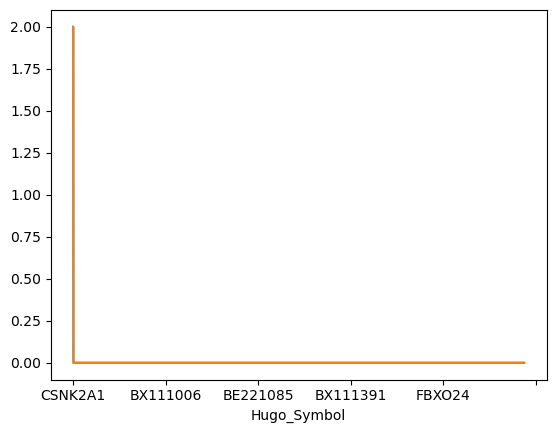

In [8]:
# 臨床データ
generate_target()
generate_features()
# 遺伝子データ
df_gene_expressions = df_mrna_agilent_microarray.copy()
df_gene_expressions = rename_duplicatged_columns(df_gene_expressions)
df_gene_expressions = drop_null4cols(df_gene_expressions)
df_gene_expressions = drop_null4raws(df_gene_expressions)

# 臨床データと遺伝子データの結合

患者の必要な特徴を含む臨床データと遺伝子データを結合する。

## 臨床データ

**必要な特徴**

目的変数
- RFS_OVER_nMONTHS  

層別化対象候補
- CLAUDIN_SUBTYPE
- NPI_CAT
- TUMOR_CAT
- LYMPH_CAT

## 遺伝子データ
遺伝子データは全ての特徴量を結合する。

In [9]:
left_features = [
    "RFS_STATUS",
    TARGET_NAME,
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]

df_merged = pd.merge(
    df_MB[left_features],
    df_gene_expressions,
    left_index=True,
    right_index=True,
)

functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_gene_expressions.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_gene_expressions.pkl"
)
df_merged.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_merged.pkl")

## 再発者の抽出

再発者のみを対象とするため、再発者を抽出する

In [10]:
df_recurrenced = df_merged[df_merged["RFS_STATUS"] == 1].drop("RFS_STATUS", axis=1)
df_recurrenced.shape

# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_recurrenced.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced.pkl"
)

## データ分割

訓練データ、検証データ、テストデータに層化分割する   
比率は(train, val, test)=(0.81, 0.09, 0.1)  
CVは行わずに通常のholdoutで検証は行う（特徴選択を毎度実施するのが厄介なため）


In [11]:
# データ分割のためのクラス
# pythonのミュータブルオブジェクトの外部操作を防ぐためにcopy()の使用&private化
class SplitDataFrame:
    def __init__(self, df):
        self.__df = df.copy()
        self.__train_size = 0.9

        self.__df_train_val = None
        self.__df_train = None
        self.__df_val = None
        self.__df_test = None

        self.__X_train_val = None
        self.__y_train_val = None
        self.__X_train = None
        self.__y_train = None
        self.__X_val = None
        self.__y_val = None
        self.__X_test = None
        self.__y_test = None

    def split_train_val_test(self):
        # train & test
        self.__df_train_val, self.__df_test = train_test_split(
            self.__df,
            train_size=self.__train_size,
            stratify=self.__df[TARGET_NAME],
            random_state=SEED,
        )
        # train & val
        self.__df_train, self.__df_val = train_test_split(
            self.__df_train_val,
            train_size=self.__train_size,
            stratify=self.__df_train_val[TARGET_NAME],
            random_state=SEED,
        )

    def split_X_y(self):
        self.__X_train, self.__y_train = (
            self.__df_train.drop(TARGET_NAME, axis=1),
            self.__df_train[TARGET_NAME],
        )
        self.__X_val, self.__y_val = (
            self.__df_val.drop(TARGET_NAME, axis=1),
            self.__df_val[TARGET_NAME],
        )
        self.__X_train_val, self.__y_train_val = (
            self.__df_train_val.drop(TARGET_NAME, axis=1),
            self.__df_train_val[TARGET_NAME],
        )
        self.__X_test, self.__y_test = (
            self.__df_test.drop(TARGET_NAME, axis=1),
            self.__df_test[TARGET_NAME],
        )

    def get_train_val(self):
        return self.__train_val.copy()

    def get_train(self):
        return self.__train.copy()

    def get_val(self):
        return self.__val.copy()

    def get_test(self):
        return self.__test.copy()

    def get_train_val_Xy(self):
        return self.__X_train_val.copy(), self.__y_train_val.copy()

    def get_train_Xy(self):
        return self.__X_train.copy(), self.__y_train.copy()

    def get_val_Xy(self):
        return self.__X_val.copy(), self.__y_val.copy()

    def get_test_Xy(self):
        return self.__X_test.copy(), self.__y_test.copy()

# 特徴選択

特徴数が多いため、特徴数を削減する

**目安**
サンプル数が767件であり、8割程度が学習に使用できる(train : val : test = 0.9*0.9 : 0.9*0.1 : 0.1)ため、学習データの1割程度の60個を選択後上限数の目安とする

In [12]:
# 適用する処理毎にdfをまとめたclass
class PreprocessDataFrame:
    def __init__(self, df_raw):
        self.__raw = df_raw.copy()
        self.__preprocessed = None
        self.__preprocess_methods = list()

    def get_preprocessed_df(self):
        return self.__preprocessed.copy()

    def get_preprocess_methods(self):
        return self.__preprocess_methods.copy()

    # feature_selection
    def set_vt(self, df):
        """
        分散によるフィルターで特徴を選択したdf
        """
        self.__preprocess_methods.append("vt")
        self.__preprocessed = df

    def set_mrmr(self, df):
        """
        mrmrで特徴を選択したdf
        """
        self.__preprocess_methods.append("mrmr")
        self.__preprocessed = df

    # scaling
    def set_std(self, df):
        """
        standarization
        """
        self.__preprocess_methods.append("std")
        self.__preprocessed = df
        # scaling

    def set_norm(self, df):
        """
        normalization
        """
        self.__preprocess_methods.append("norm")
        self.__preprocessed = df

    # sampling
    def set_smote(self, df):
        """
        smote
        """
        self.__preprocess_methods.append("smote")
        self.__preprocessed = df

## 分割データ毎に前処理を行う関数の実装


In [13]:
def save_preprocessed_df(
    list_train: list(),
    list_val: list(),
    list_train_val: list(),
    list_test: list(),
    save_file_path: str = ".",
    save_file_name: str = "sample",
):
    """
    params
    list_train: [X_train, y_train]
    list_val: [X_val, y_val]
    list_train_val: [X_train_val, y_train_val]
    list_test: [X_val, y_val]
    """
    functions.make_dir("{0}/train".format(save_file_path))
    list_train[0].to_pickle(
        "{0}/train/X_{1}.pkl".format(save_file_path, save_file_name)
    )
    list_train[1].to_pickle(
        "{0}/train/y_{1}.pkl".format(save_file_path, save_file_name)
    )
    functions.make_dir("{0}/val".format(save_file_path))
    list_val[0].to_pickle("{0}/val/X_{1}.pkl".format(save_file_path, save_file_name))
    list_val[1].to_pickle("{0}/val/y_{1}.pkl".format(save_file_path, save_file_name))

    functions.make_dir("{0}/train_val".format(save_file_path))
    list_train_val[0].to_pickle(
        "{0}/train_val/X_{1}.pkl".format(save_file_path, save_file_name)
    )
    list_train_val[1].to_pickle(
        "{0}/train_val/y_{1}.pkl".format(save_file_path, save_file_name)
    )
    functions.make_dir("{0}/test".format(save_file_path))
    list_test[0].to_pickle("{0}/test/X_{1}.pkl".format(save_file_path, save_file_name))
    list_test[1].to_pickle("{0}/test/y_{1}.pkl".format(save_file_path, save_file_name))

## scaling関数

In [14]:
# 標準化を行う関数
def transform_std(X_train: pd.DataFrame(), X_test: pd.DataFrame() = None):
    std = StandardScaler()
    std.fit(X_train)
    X_train_std = pd.DataFrame(
        std.transform(X_train), index=X_train.index, columns=X_train.columns
    )
    if X_test is None:
        return X_train_std
    X_test_std = pd.DataFrame(
        std.transform(X_test), index=X_test.index, columns=X_test.columns
    )
    return X_train_std, X_test_std


# 正規化を行う関数
def transform_norm(
    X_train: pd.DataFrame(), X_test: pd.DataFrame() = None
) -> pd.DataFrame():
    mm = MinMaxScaler()
    mm.fit(X_train)
    X_train_norm = pd.DataFrame(
        mm.transform(X_train), index=X_train.index, columns=X_train.columns
    )
    if X_test is None:
        return X_train_norm
    X_test_norm = pd.DataFrame(
        mm.transform(X_test), index=X_test.index, columns=X_test.columns
    )
    return X_train_norm, X_test_norm

In [15]:
def preprocess_df(
    df: pd.DataFrame(),
    feature_selection_method: str = None,
    scaling_method: str = None,
    sampling_method: str = None,
    save_file_path: str = None,
    save_file_name: str = None,
    is_save: bool = False,
):
    _df = df.copy()

    # データが少なすぎる場合は特徴選択しない
    if _df.shape[0] < 100:
        # print("data size is too small")
        return

    # データ分割
    sp = SplitDataFrame(_df)
    sp.split_train_val_test()
    sp.split_X_y()

    X_train, y_train = sp.get_train_Xy()
    X_val, y_val = sp.get_val_Xy()
    X_train_val, y_train_val = sp.get_train_val_Xy()
    X_test, y_test = sp.get_test_Xy()

    # class初期化
    pd_train = PreprocessDataFrame(X_train)
    pd_val = PreprocessDataFrame(X_val)
    pd_train_val = PreprocessDataFrame(X_train_val)
    pd_test = PreprocessDataFrame(X_test)

    # feature selection
    if feature_selection_method == "none":
        pass
    elif feature_selection_method == "vt":
        # 分散値上位の特徴を抽出
        features = (
            X_train.var().sort_values().tail(X_train.shape[0] // 10).index
        )  # 学習データの1/10サイズ
        pd_train.set_vt(X_train[features])
        pd_val.set_vt(X_val[features])

        features = (
            X_train_val.var()
            .sort_values()
            .tail(X_train_val.shape[0] // 10)
            .index  # 学習データの1/10サイズ
        )
        pd_train_val.set_vt(X_train_val[features])
        pd_test.set_vt(X_test[features])
    elif feature_selection_method == "mrmr":
        features = mrmr.mrmr_classif(
            X=X_train,
            y=y_train,
            K=X_train.shape[0] // 10,  # 学習データの1/10サイズ
            show_progress=False,
        )
        pd_train.set_mrmr(X_train[features])
        pd_val.set_mrmr(X_val[features])

        features = mrmr.mrmr_classif(
            X=X_train_val,
            y=y_train_val,
            K=X_train_val.shape[0] // 10,  # 学習データの1/10サイズ
            show_progress=False,
        )
        pd_train_val.set_mrmr(X_train_val[features])
        pd_test.set_mrmr(X_test[features])
    else:
        print("undefined feature_selection_method")
        return

    # scaling
    if scaling_method == "none":
        pass
    elif scaling_method == "std":
        X_train, X_val = transform_std(
            pd_train.get_preprocessed_df(), pd_val.get_preprocessed_df()
        )
        X_train_val, X_test = transform_std(
            pd_train_val.get_preprocessed_df(), pd_test.get_preprocessed_df()
        )
        pd_train.set_std(X_train)
        pd_val.set_std(X_val)
        pd_train_val.set_std(X_train_val)
        pd_test.set_std(X_test)
    elif scaling_method == "norm":
        X_train, X_val = transform_norm(
            pd_train.get_preprocessed_df(), pd_val.get_preprocessed_df()
        )
        X_train_val, X_test = transform_norm(
            pd_train_val.get_preprocessed_df(), pd_test.get_preprocessed_df()
        )
        pd_train.set_norm(X_train)
        pd_val.set_std(X_val)
        pd_train_val.set_std(X_train_val)
        pd_test.set_std(X_test)
    else:
        print("undefined scaling_method")
        return

    # sampling
    if sampling_method == "none":
        pass
    elif sampling_method == "smote":
        smote = SMOTE(sampling_strategy="minority", random_state=SEED)
        X_train, y_train = smote.fit_resample(pd_train.get_preprocessed_df(), y_train)
        smote = SMOTE(sampling_strategy="minority", random_state=SEED)
        X_train_val, y_train_val = smote.fit_resample(
            pd_train_val.get_preprocessed_df(), y_train_val
        )
        pd_train.set_smote(X_train)
        pd_train_val.set_smote(X_train_val)
    else:
        print("undefined sampling_method")
        return

    # 保存
    if is_save:
        save_preprocessed_df(
            list_train=[pd_train.get_preprocessed_df(), y_train],
            list_val=[pd_val.get_preprocessed_df(), y_val],
            list_train_val=[pd_train_val.get_preprocessed_df(), y_train_val],
            list_test=[pd_test.get_preprocessed_df(), y_test],
            save_file_path=save_file_path,
            save_file_name=save_file_name,
        )

In [ ]:
is_save = True

# サブグループ削除（一時的に）
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]

drop_columns = [
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]

feature_selection_methods = ["vt", "mrmr"]

scaling_methods = ["std", "norm"]

sampling_methods = ["none", "smote"]

for feature_selection_method, scaling_method, sampling_method in tqdm(
    itertools.product(feature_selection_methods, scaling_methods, sampling_methods)
):
    preprocess_order = "{0}_{1}_{2}".format(
        feature_selection_method, scaling_method, sampling_method
    )
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループ毎への適用
            df = df_recurrenced[df_recurrenced[subgroup_column] == subgroup].drop(
                drop_columns, axis=1
            )
            output_file_path = "./{0}/{1}/{2}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                preprocess_order,
            )
            functions.make_dir(output_file_path)
            preprocess_df(
                df,
                feature_selection_method=feature_selection_method,
                scaling_method=scaling_method,
                sampling_method=sampling_method,
                save_file_path=output_file_path,
                save_file_name=subgroup,
                is_save=is_save,
            )
            del df

4it [01:04, 15.85s/it]